In [1]:
import cv2
from matplotlib import pyplot as plt
from random import random
import cairo
import numpy as np
import math
%matplotlib inline
import time

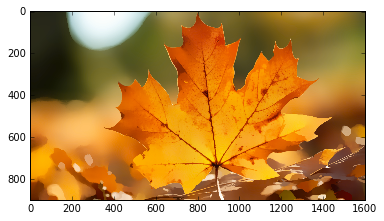

In [29]:
Image1 = cv2.imread('./images/intermediate/segmented/leaf-seg_20_13.png')
Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
plt.imshow(Image1)
plt.show()

## Image Segmentation

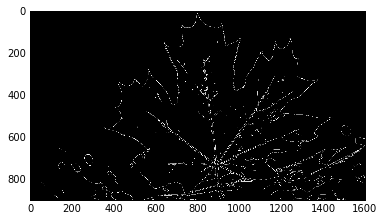

In [30]:
segmented = Image1
canny = cv2.Canny(Image1,200,300)
plt.imshow(canny,cmap='gray')
plt.show()

In [31]:
edges_inv = (255 - canny)

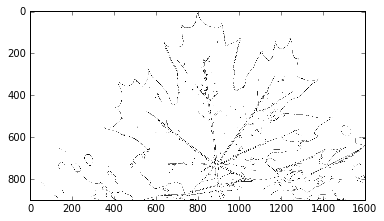

In [32]:
plt.imshow(edges_inv,cmap='gray')
plt.show()

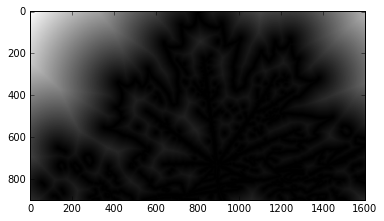

In [33]:
dist_transform = cv2.distanceTransform(edges_inv,cv2.DIST_L2,0) 
plt.imshow(dist_transform,cmap='gray')

In [34]:
img  = segmented

In [35]:
SIZE_X = img.shape[1]
SIZE_Y = img.shape[0]
SIZE = min(SIZE_X,SIZE_Y)

LINEWIDTH = 0.1

TWOPI = 2.0*3.14
BACK = [255,0,0,1]

## Functions for creating circles

In [36]:
def add_new_circles(circles,r,t,e):
    for x in range(2*r,SIZE_X- r):
        for y in range(2*r,SIZE_Y - r):
            a=True
            if dist_transform[y,x]>r:
                p=(int)((dist_transform[y,x]+1)/2)
                if p>e:
                    p=r
                if (is_fill[x,y]==0)&(x-p>=0)&(x+p<SIZE_X)&(y-p>=0)&(y+p<SIZE_Y):
                    for rt in range(x-p,x+p+1):
                        if rt>SIZE_X:
                            break
                        yu=rt-x
                        for ty in range(y-p,y+p+1):
                            if ty>SIZE_Y:
                                break
                            op=ty-y
                            if yu*yu+op*op<(p+1)*(p+1):
                                if is_fill[rt,ty]==1:
                                    a=False
                                    break
                            if a==False:
                                break
                    
                    if a==True:
                        circles.append({
                        'x': x, 
                        'y': y, 
                        'r': p,
                        }) 
                        for st in range(x-p,x+p+1):
                            ui=st-x
                            if st>SIZE_X:
                                break
                            for en in range(y-p,y+p+1):
                                iu=en-y
                                if en>SIZE_Y:
                                    break
                                if ui*ui+iu*iu<=(p+1)*(p+1):
                                    is_fill[st,en]=1    

                        
                        y=y+p*2+r;

def show(img_clr,ctx, circles):
    for c in circles:
        rgb = img_clr[int(c['y']),int(c['x'])]
        rgba = [rgb[0]/255, rgb[1]/255,rgb[2]/255, 1.0]
        ctx.set_source_rgba(*rgba)
        ctx.arc(c['x'], c['y'], c['r'], 0, TWOPI)
        ctx.fill()
        ctx.set_source_rgba(*[0,0,0,1])
        ctx.arc(c['x'], c['y'], c['r'], 0, TWOPI)
        ctx.stroke()


In [38]:
s = time.time()
image = cairo.ImageSurface.create_from_png('./images/intermediate/background/leaf-back.png')
buffer_surf = cairo.ImageSurface(cairo.FORMAT_ARGB32, SIZE_X, SIZE_Y)
buffer = cairo.Context(buffer_surf)
buffer.set_source_surface(image, 0,0)
# buffer.set_source_rgba(0,0,0,1)
buffer.paint()
 
# buffer.scale(SIZE_X, SIZE_Y)

buffer.rectangle(0.0, 0.0, 1.0, 1.0)
buffer.fill()
circles = []
is_fill = np.zeros([SIZE_X+1,SIZE_Y+1])
D = [ 50,20,10, 5, 3, 2]
add_new_circles(circles,50,50,500)
print(time.time()-s)
for i in range(len(D)):
    if i==0:
        continue
    add_new_circles(circles,D[i],D[i],D[i-1])
    print(time.time()-s)

buffer.set_line_width(1)
show(img,buffer, circles)
print (len(circles))
buffer_surf.write_to_png('./images/output/leaf_out.png')
print (time.time()-s)

24.559860706329346
49.166730880737305
67.4628975391388
85.5626814365387
103.59739112854004
120.86741662025452
11025
121.42606735229492


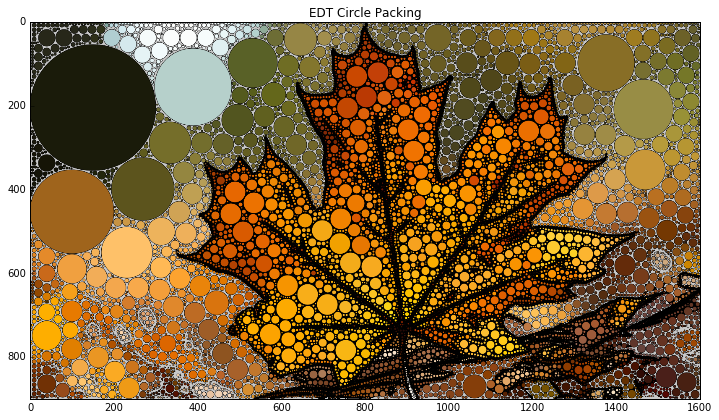

In [39]:
result = cv2.imread('./images/output/leaf_out.png')
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(result)
plt.title('EDT Circle Packing')
plt.show()